In this HW, you will implement a CycleGAN for selfie-to-anime and anime-to-selfie unpaired translations. You can read more about CycleGANs [here](https://machinelearningmastery.com/what-is-cyclegan/).

You are to create and train your CycleGAN on the provided dataset. After training, show 10 selfie-to-anime and and anime-to-selfie from the test set. Also, you show you models performance on three random images from internet for both modes. You can also use your own selfie if you want.

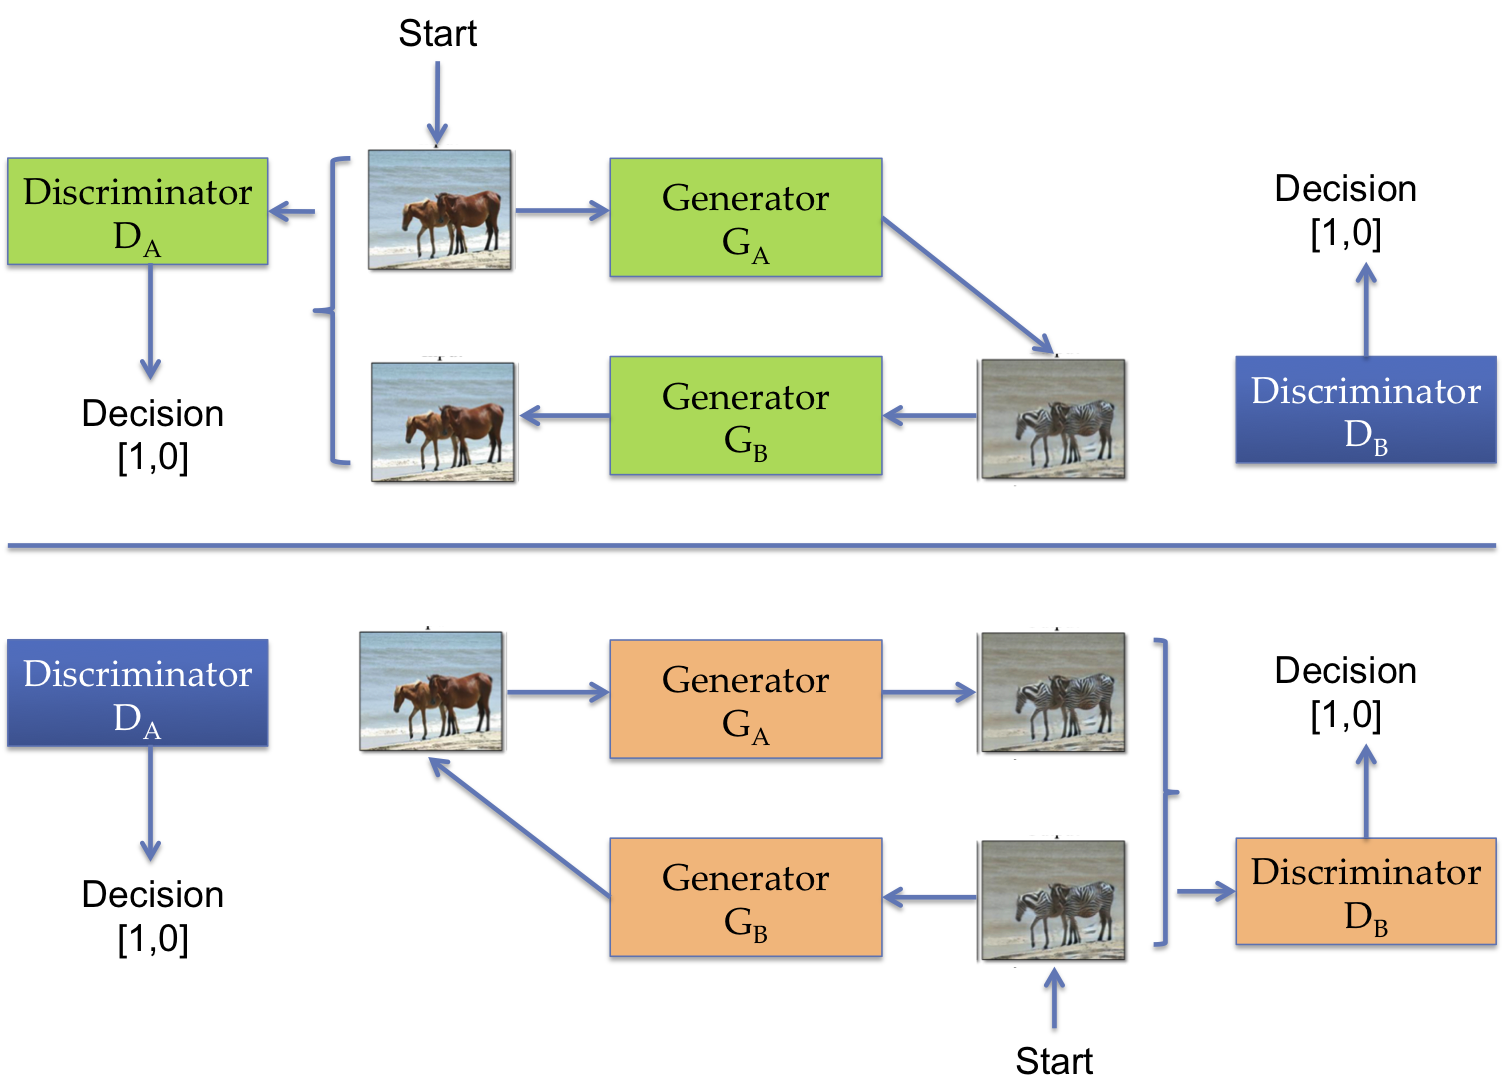

[Image Source](https://www.oreilly.com/library/view/hands-on-artificial-intelligence/9781788836067/c2e7d914-4e45-4528-8627-c590d19107ef.xhtml)

In [18]:
from IPython.display import clear_output

In [19]:
%pip install gdown
clear_output()

In [20]:
import gdown
gdown.download("https://drive.google.com/uc?id=1xOWj1UVgp6NKMT3HbPhBbtq2A4EDkghF")

Downloading...
From (original): https://drive.google.com/uc?id=1xOWj1UVgp6NKMT3HbPhBbtq2A4EDkghF
From (redirected): https://drive.google.com/uc?id=1xOWj1UVgp6NKMT3HbPhBbtq2A4EDkghF&confirm=t&uuid=ed94455a-348c-42c3-bd67-aa631baaccb2
To: /kaggle/working/selfie2anime.zip
100%|██████████| 409M/409M [00:01<00:00, 243MB/s] 


'selfie2anime.zip'

In [21]:
!unzip selfie2anime.zip
clear_output()

## Dataset

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.io import read_image
from os import listdir
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [23]:
class MyDataset(Dataset):
    def __init__(self, root='', train=True, transform=None):
        self.split = 'train' if train else 'test'
        self.root = root
        self.transforms = transform
        self.dataA = [join(f'{self.split}A', f) for f in listdir(join(root, f'{self.split}A'))]
        self.dataB = [join(f'{self.split}B', f) for f in listdir(join(root, f'{self.split}B'))]
    
    def __len__(self):
        return len(self.dataA)
    
    def __getitem__(self, idx):
        real = read_image(self.dataA[idx]).type(torch.float) / 255.0
        anime = read_image(np.random.choice(self.dataB)).type(torch.float) / 255.0
        if self.transforms:
            real = self.transforms(real)
            anime = self.transforms(anime)
        return real, anime

In [24]:
set_transforms = transforms.Compose([
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Resize((128, 128))
])

In [25]:
train_data = MyDataset(train=True, transform=set_transforms)
test_data = MyDataset(train=False, transform=set_transforms)

In [38]:
BATCH_SIZE = 16

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [39]:
def denormalize_image(image):
    mean = (0.5, 0.5, 0.5)
    std = (0.5, 0.5, 0.5)
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    denormalized_image = image * std + mean
    return denormalized_image

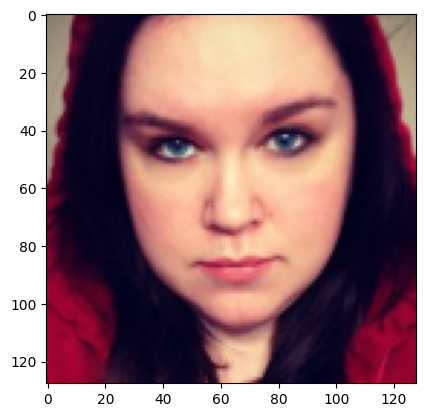

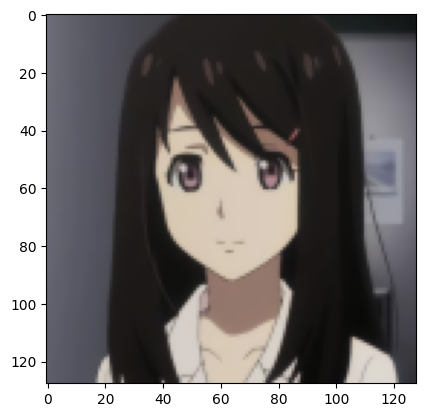

In [40]:
real, anime = train_data[0]
plt.imshow(denormalize_image(real).permute(1, 2, 0))
plt.show()
plt.imshow(denormalize_image(anime).permute(1, 2, 0))
plt.show()

## Model

In [41]:
def unet_conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1),
        nn.InstanceNorm2d(out_channels),
        nn.LeakyReLU(inplace=True)
    )

In [42]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_block1 = unet_conv_block(in_channels, out_channels)
        self.conv_block2 = unet_conv_block(out_channels, out_channels)
        self.pool = nn.AvgPool2d(kernel_size=2)

    def forward(self, x):
        x1 = self.conv_block1(x)
        x2 = self.conv_block2(x1)
        x3 = self.pool(x2)
        return x3, x1

In [43]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.trans_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, padding=0, stride=2)
        self.conv_block1 = unet_conv_block(in_channels, out_channels)
        self.conv_block2 = unet_conv_block(out_channels, out_channels)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x, enc, dropout=False):
        x = self.trans_conv(x)
        x = torch.cat([x, enc], dim=1)
        if dropout: x = self.dropout(x)
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        return x

In [44]:
class UNetGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = EncoderBlock(3, 64)
        self.enc2 = EncoderBlock(64, 128)
        self.enc3 = EncoderBlock(128, 256)
        self.enc4 = EncoderBlock(256, 512)

        self.bottleneck = nn.Sequential(
            unet_conv_block(512, 1024),
            unet_conv_block(1024, 1024)
        )

        self.dec1 = DecoderBlock(1024, 512)
        self.dec2 = DecoderBlock(512, 256)
        self.dec3 = DecoderBlock(256, 128)
        self.dec4 = DecoderBlock(128, 64)

        self.final = nn.Conv2d(64, 3, kernel_size=1, padding=0)

    def forward(self, x):
        x, enc1 = self.enc1(x)
        x, enc2 = self.enc2(x)
        x, enc3 = self.enc3(x)
        x, enc4 = self.enc4(x)

        x = self.bottleneck(x)

        x = self.dec1(x, enc4, dropout=True)
        x = self.dec2(x, enc3, dropout=True)
        x = self.dec3(x, enc2, dropout=True)
        x = self.dec4(x, enc1, dropout=True)

        x = self.final(x)

        return x

In [45]:
def conv_block(in_channels, out_channels, relu=True, stride=1, pool=False):
    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1),
        nn.InstanceNorm2d(out_channels),
    ]
    if relu: layers.append(nn.LeakyReLU(inplace=True))
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv_block(3, 64)

        self.res1 = nn.Sequential(conv_block(64, 64, pool=True), conv_block(64, 64, relu=False)) # 128 x 128
        self.upsample1 = nn.Conv2d(64, 64, kernel_size=2, stride=2)

        self.res2 = nn.Sequential(conv_block(64, 128, pool=True), conv_block(128, 128, relu=False)) # 64 x 64
        self.upsample2 = nn.Conv2d(64, 128, kernel_size=2, stride=2)

        self.res3 = nn.Sequential(conv_block(128, 256, pool=True), conv_block(256, 256, relu=False)) # 32 x 32
        self.upsample3 = nn.Conv2d(128, 256, kernel_size=2, stride=2)

        self.res4 = nn.Sequential(conv_block(256, 512, pool=True), conv_block(512, 512, relu=False)) # 16 x 16
        self.upsample4 = nn.Conv2d(256, 512, kernel_size=2, stride=2)

        self.fc = nn.Sequential(
            nn.AvgPool2d(kernel_size=2), # 8 x 8
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 2048),
            nn.LeakyReLU(),
            nn.Linear(2048, 1)
        )

        self.relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(self.res1(x) + self.upsample1(x))
        x = self.relu(self.res2(x) + self.upsample2(x))
        x = self.relu(self.res3(x) + self.upsample3(x))
        x = self.relu(self.res4(x) + self.upsample4(x))
        x = self.fc(x)
        return x

## Training

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the generators and discriminators
generator_A2B = UNetGenerator().to(device)
generator_B2A = UNetGenerator().to(device)
discriminator_A = ResNet9Discriminator().to(device)
discriminator_B = ResNet9Discriminator().to(device)

# generator_A2B = nn.DataParallel(generator_A2B).to(device)
# generator_B2A = nn.DataParallel(generator_B2A).to(device)
# discriminator_A = nn.DataParallel(discriminator_A).to(device)
# discriminator_B = nn.DataParallel(discriminator_B).to(device)

# Loss functions
criterion_gan = nn.BCEWithLogitsLoss()
criterion_cycle = nn.L1Loss()

# Optimizers
optimizer_g = optim.AdamW(
    list(generator_A2B.parameters()) + list(generator_B2A.parameters()), lr=3e-4
)
optimizer_d_A = optim.AdamW(discriminator_A.parameters(), lr=3e-4)
optimizer_d_B = optim.AdamW(discriminator_B.parameters(), lr=3e-4)

epochs = 10
lambda_cycle = 10.0  # Weight for cycle-consistency loss

train_losses_g = []
train_losses_d_A = []
train_losses_d_B = []
val_losses_g = []

def train(epochs=10):
    # Training loop
    for epoch in range(epochs):
        generator_A2B.train()
        generator_B2A.train()
        discriminator_A.train()
        discriminator_B.train()

        epoch_loss_g = 0
        epoch_loss_d_A = 0
        epoch_loss_d_B = 0

        loop = tqdm(train_loader, leave=True)

        for batch_idx, (real_A, real_B) in enumerate(loop):
            real_label = torch.full((real_A.size(0), 1), 0.9, dtype=torch.float32, device=device)
            fake_label = torch.full((real_A.size(0), 1), 0.1, dtype=torch.float32, device=device)

            real_A, real_B = real_A.to(device), real_B.to(device)

            # DISCRIMINATORS

            # Discriminator A
            optimizer_d_A.zero_grad()
            fake_A = generator_B2A(real_B).detach()
            loss_d_A_real = criterion_gan(discriminator_A(real_A), real_label)
            loss_d_A_fake = criterion_gan(discriminator_A(fake_A), fake_label)
            loss_d_A = (loss_d_A_real + loss_d_A_fake) / 2
            loss_d_A.backward()
            optimizer_d_A.step()

            # Discriminator B
            optimizer_d_B.zero_grad()
            fake_B = generator_A2B(real_A).detach()
            loss_d_B_real = criterion_gan(discriminator_B(real_B), real_label)
            loss_d_B_fake = criterion_gan(discriminator_B(fake_B), fake_label)
            loss_d_B = (loss_d_B_real + loss_d_B_fake) / 2
            loss_d_B.backward()
            optimizer_d_B.step()

            # GENERATORS

            optimizer_g.zero_grad()

            # GAN loss
            loss_g_A2B = criterion_gan(discriminator_B(generator_A2B(real_A)), real_label)
            loss_g_B2A = criterion_gan(discriminator_A(generator_B2A(real_B)), real_label)

            # Cycle-consistency loss
            cycle_A = generator_B2A(fake_B)
            cycle_B = generator_A2B(fake_A)
            loss_cycle_A = criterion_cycle(cycle_A, real_A) * lambda_cycle
            loss_cycle_B = criterion_cycle(cycle_B, real_B) * lambda_cycle

            # Total Generator Loss
            loss_g = loss_g_A2B + loss_g_B2A + loss_cycle_A + loss_cycle_B
            loss_g.backward()
            optimizer_g.step()

            # Record losses
            train_losses_g.append(loss_g.item())
            train_losses_d_A.append(loss_d_A.item())
            train_losses_d_B.append(loss_d_B.item())

            epoch_loss_g += loss_g.item()
            epoch_loss_d_A += loss_d_A.item()
            epoch_loss_d_B += loss_d_B.item()

            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss_g=loss_g.item(), loss_d_A=loss_d_A.item(), loss_d_B=loss_d_B.item())

        # Average losses for this epoch
        avg_loss_g = epoch_loss_g / len(train_loader)
        avg_loss_d_A = epoch_loss_d_A / len(train_loader)
        avg_loss_d_B = epoch_loss_d_B / len(train_loader)

        # Validation
        generator_A2B.eval()
        generator_B2A.eval()
        val_loss_g = 0
        with torch.no_grad():
            for real_A, real_B in test_loader:
                real_A, real_B = real_A.to(device), real_B.to(device)
                fake_B = generator_A2B(real_A)
                fake_A = generator_B2A(real_B)
                cycle_A = generator_B2A(fake_B)
                cycle_B = generator_A2B(fake_A)
                val_loss_g += (
                    criterion_cycle(cycle_A, real_A).item() + criterion_cycle(cycle_B, real_B).item()
                )

        val_loss_g /= len(test_loader)
        val_losses_g.append(val_loss_g)

        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss G: {avg_loss_g:.4f}, "
              f"Train Loss D_A: {avg_loss_d_A:.4f}, Train Loss D_B: {avg_loss_d_B:.4f}, "
              f"Val Loss G: {val_loss_g:.4f}")

train()

Epoch [1/10]: 100%|██████████| 213/213 [02:53<00:00,  1.23it/s, loss_d_A=0.399, loss_d_B=0.408, loss_g=10.8]


Epoch [1/10] - Train Loss G: 10.3508, Train Loss D_A: 0.4897, Train Loss D_B: 0.4562, Val Loss G: 0.6609


Epoch [2/10]: 100%|██████████| 213/213 [02:53<00:00,  1.23it/s, loss_d_A=0.338, loss_d_B=0.422, loss_g=11.6]


Epoch [2/10] - Train Loss G: 10.8237, Train Loss D_A: 0.3924, Train Loss D_B: 0.3829, Val Loss G: 0.6546


Epoch [3/10]: 100%|██████████| 213/213 [02:53<00:00,  1.23it/s, loss_d_A=0.356, loss_d_B=0.36, loss_g=9.38] 


Epoch [3/10] - Train Loss G: 10.8538, Train Loss D_A: 0.3718, Train Loss D_B: 0.3698, Val Loss G: 0.6051


Epoch [4/10]: 100%|██████████| 213/213 [02:53<00:00,  1.23it/s, loss_d_A=0.422, loss_d_B=0.327, loss_g=9.77]


Epoch [4/10] - Train Loss G: 10.2519, Train Loss D_A: 0.3501, Train Loss D_B: 0.3587, Val Loss G: 0.5580


Epoch [5/10]: 100%|██████████| 213/213 [02:53<00:00,  1.23it/s, loss_d_A=0.352, loss_d_B=0.328, loss_g=10.2]


Epoch [5/10] - Train Loss G: 9.6664, Train Loss D_A: 0.3545, Train Loss D_B: 0.3422, Val Loss G: 0.5350


Epoch [6/10]: 100%|██████████| 213/213 [02:53<00:00,  1.23it/s, loss_d_A=0.33, loss_d_B=0.326, loss_g=9.43] 


Epoch [6/10] - Train Loss G: 9.4064, Train Loss D_A: 0.3502, Train Loss D_B: 0.3444, Val Loss G: 0.4507


Epoch [7/10]: 100%|██████████| 213/213 [02:53<00:00,  1.23it/s, loss_d_A=0.33, loss_d_B=0.327, loss_g=9.11] 


Epoch [7/10] - Train Loss G: 9.1250, Train Loss D_A: 0.3484, Train Loss D_B: 0.3265, Val Loss G: 0.4911


Epoch [8/10]: 100%|██████████| 213/213 [02:53<00:00,  1.23it/s, loss_d_A=0.327, loss_d_B=0.328, loss_g=8.52]


Epoch [8/10] - Train Loss G: 8.8661, Train Loss D_A: 0.3324, Train Loss D_B: 0.3366, Val Loss G: 0.4498


Epoch [9/10]: 100%|██████████| 213/213 [02:53<00:00,  1.23it/s, loss_d_A=0.327, loss_d_B=0.365, loss_g=9.43]


Epoch [9/10] - Train Loss G: 8.6381, Train Loss D_A: 0.3279, Train Loss D_B: 0.3314, Val Loss G: 0.4357


Epoch [10/10]: 100%|██████████| 213/213 [02:53<00:00,  1.23it/s, loss_d_A=0.401, loss_d_B=0.327, loss_g=8.89]


Epoch [10/10] - Train Loss G: 8.7062, Train Loss D_A: 0.3453, Train Loss D_B: 0.3341, Val Loss G: 0.4744


In [63]:
train(10)

Epoch [1/10]: 100%|██████████| 213/213 [02:53<00:00,  1.23it/s, loss_d_A=0.326, loss_d_B=0.329, loss_g=8.55]


Epoch [1/10] - Train Loss G: 8.2778, Train Loss D_A: 0.3352, Train Loss D_B: 0.3306, Val Loss G: 0.3762


Epoch [2/10]: 100%|██████████| 213/213 [02:53<00:00,  1.23it/s, loss_d_A=0.327, loss_d_B=0.355, loss_g=8.31]


Epoch [2/10] - Train Loss G: 8.1916, Train Loss D_A: 0.3284, Train Loss D_B: 0.3351, Val Loss G: 0.3837


Epoch [3/10]: 100%|██████████| 213/213 [02:53<00:00,  1.23it/s, loss_d_A=0.326, loss_d_B=0.329, loss_g=7.78]


Epoch [3/10] - Train Loss G: 8.2822, Train Loss D_A: 0.3310, Train Loss D_B: 0.3328, Val Loss G: 0.3813


Epoch [4/10]: 100%|██████████| 213/213 [02:53<00:00,  1.23it/s, loss_d_A=0.362, loss_d_B=0.335, loss_g=7.82]


Epoch [4/10] - Train Loss G: 8.4679, Train Loss D_A: 0.3283, Train Loss D_B: 0.3437, Val Loss G: 0.3614


Epoch [5/10]: 100%|██████████| 213/213 [02:53<00:00,  1.23it/s, loss_d_A=0.325, loss_d_B=0.325, loss_g=8.45]


Epoch [5/10] - Train Loss G: 8.2292, Train Loss D_A: 0.3269, Train Loss D_B: 0.3270, Val Loss G: 0.3814


Epoch [6/10]: 100%|██████████| 213/213 [02:53<00:00,  1.23it/s, loss_d_A=0.325, loss_d_B=0.325, loss_g=8.39]


Epoch [6/10] - Train Loss G: 8.2040, Train Loss D_A: 0.3260, Train Loss D_B: 0.3255, Val Loss G: 0.3742


Epoch [7/10]: 100%|██████████| 213/213 [02:53<00:00,  1.23it/s, loss_d_A=0.325, loss_d_B=0.325, loss_g=7.5] 


Epoch [7/10] - Train Loss G: 8.1933, Train Loss D_A: 0.3254, Train Loss D_B: 0.3255, Val Loss G: 0.3904


Epoch [8/10]: 100%|██████████| 213/213 [02:53<00:00,  1.23it/s, loss_d_A=0.325, loss_d_B=0.327, loss_g=8.61]


Epoch [8/10] - Train Loss G: 8.4387, Train Loss D_A: 0.3253, Train Loss D_B: 0.3263, Val Loss G: 0.4013


Epoch [9/10]: 100%|██████████| 213/213 [02:53<00:00,  1.23it/s, loss_d_A=0.333, loss_d_B=0.325, loss_g=8.56]


Epoch [9/10] - Train Loss G: 8.4705, Train Loss D_A: 0.3430, Train Loss D_B: 0.3253, Val Loss G: 0.4051


Epoch [10/10]: 100%|██████████| 213/213 [02:53<00:00,  1.23it/s, loss_d_A=0.345, loss_d_B=0.357, loss_g=6.94]


Epoch [10/10] - Train Loss G: 8.3131, Train Loss D_A: 0.3445, Train Loss D_B: 0.3286, Val Loss G: 0.3626


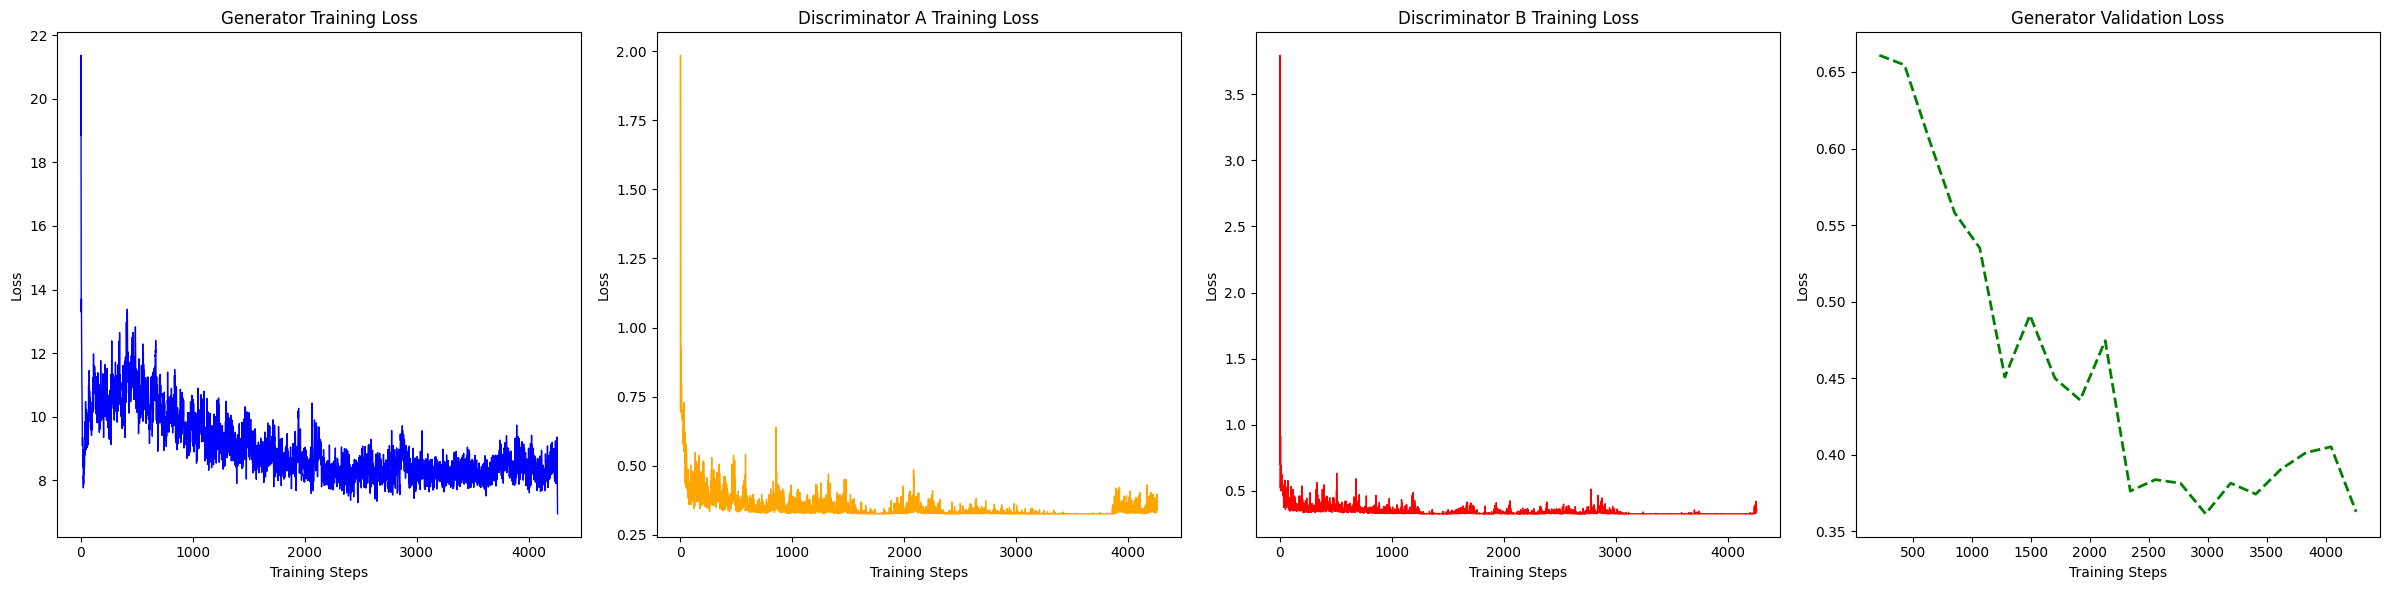

In [64]:
import matplotlib.pyplot as plt

def plot_losses(train_losses_g, train_losses_d_A, train_losses_d_B, val_losses_g):
    fig, axs = plt.subplots(1, 4, figsize=(24, 6))

    axs[0].plot(train_losses_g, color='blue', linewidth=1)
    axs[0].set_title('Generator Training Loss')
    axs[0].set_xlabel('Training Steps')
    axs[0].set_ylabel('Loss')

    axs[1].plot(train_losses_d_A, color='orange', linewidth=1)
    axs[1].set_title('Discriminator A Training Loss')
    axs[1].set_xlabel('Training Steps')
    axs[1].set_ylabel('Loss')

    axs[2].plot(train_losses_d_B, color='red', linewidth=1)
    axs[2].set_title('Discriminator B Training Loss')
    axs[2].set_xlabel('Training Steps')
    axs[2].set_ylabel('Loss')

    val_steps = len(train_losses_g) // len(val_losses_g)
    val_x = [val_steps * (i + 1) for i in range(len(val_losses_g))]
    axs[3].plot(val_x, val_losses_g, color='green', linewidth=2, linestyle='--')
    axs[3].set_title('Generator Validation Loss')
    axs[3].set_xlabel('Training Steps')
    axs[3].set_ylabel('Loss')

    plt.tight_layout()
    plt.show()

plot_losses(train_losses_g, train_losses_d_A, train_losses_d_B, val_losses_g)

## Results

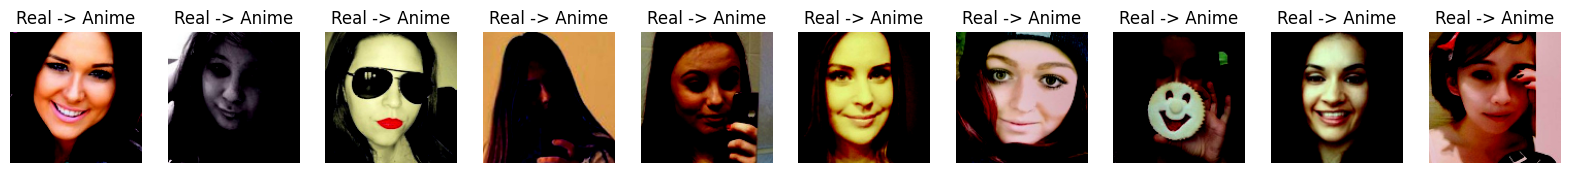

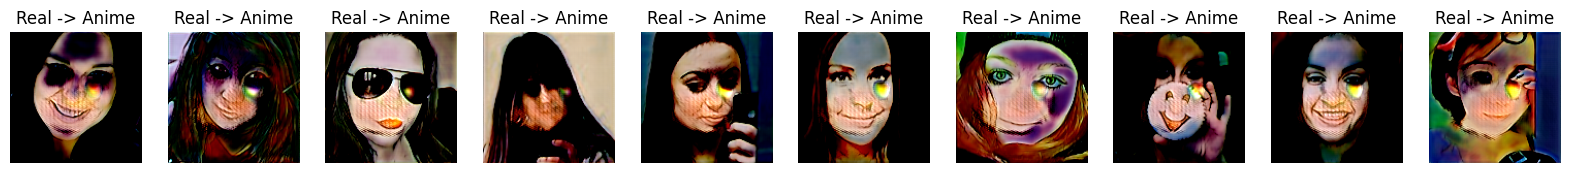

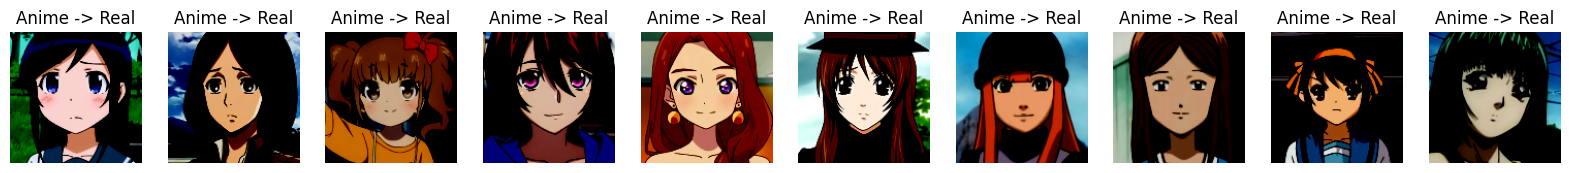

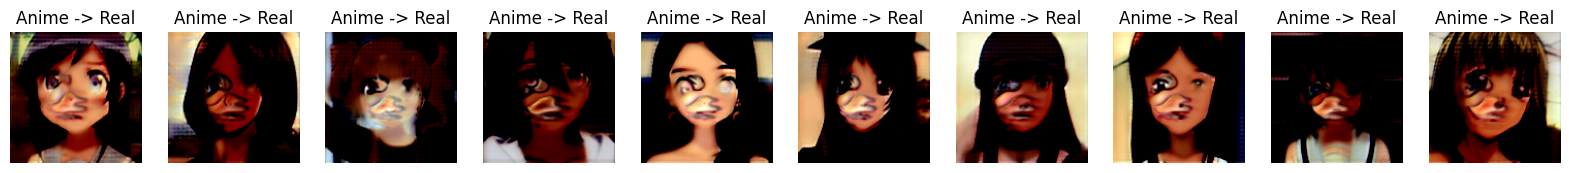

In [65]:
result_loader = DataLoader(test_data, batch_size=10)

def show_images(images, titles=None):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
    if titles is None:
        titles = [''] * len(images)
    for i, (img, title) in enumerate(zip(images, titles)):
        img = img.permute(1, 2, 0).cpu().numpy()
        axes[i].imshow(img)
        axes[i].set_title(title)
        axes[i].axis('off')
    plt.show()

generator_A2B.eval()
generator_B2A.eval()

for real_A, real_B in result_loader:
    real_A, real_B = real_A.to(device), real_B.to(device)

    with torch.no_grad():
        fake_B = generator_A2B(real_A)
        fake_A = generator_B2A(real_B)

    titles_real_to_anime = ["Real -> Anime"] * real_A.size(0)
    titles_anime_to_real = ["Anime -> Real"] * real_B.size(0)

    show_images([img for img in real_A], titles=titles_real_to_anime)
    show_images([img for img in fake_B], titles=titles_real_to_anime)

    show_images([img for img in real_B], titles=titles_anime_to_real)
    show_images([img for img in fake_A], titles=titles_anime_to_real)
    break
